In [16]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from torch.utils.data import (
    Dataset,
    DataLoader,
)
import pandas as pd
import os
import imageio
import cv2
from PIL import Image


In [17]:
class ChairAndDoorsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        print(self.annotations)
        self.root_dir = root_dir
        self.transform = transform
    
    def __new__(cls, csv_file, root_dir, transform=None):
        return super(ChairAndDoorsDataset, cls).__new__(cls)
     
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        
        image = cv2.imread(img_path)
        image=Image.fromarray(image)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [18]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [19]:
dataset = ChairAndDoorsDataset(
    csv_file="labels.csv",
    root_dir="ChairDoorData",
    transform=train_transforms)

batch_size=12
train_set, test_set = torch.utils.data.random_split(dataset, [678, 300])
train_loader = DataLoader(dataset=train_set, batch_size=12, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=12, shuffle=True)

      chair.0.jpg  0
0     chair.1.jpg  0
1     chair.2.jpg  0
2     chair.3.jpg  0
3     chair.4.jpg  0
4     chair.5.jpg  0
..            ... ..
973  door.326.jpg  1
974  door.327.jpg  1
975  door.328.jpg  1
976  door.329.jpg  1
977  door.330.jpg  1

[978 rows x 2 columns]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

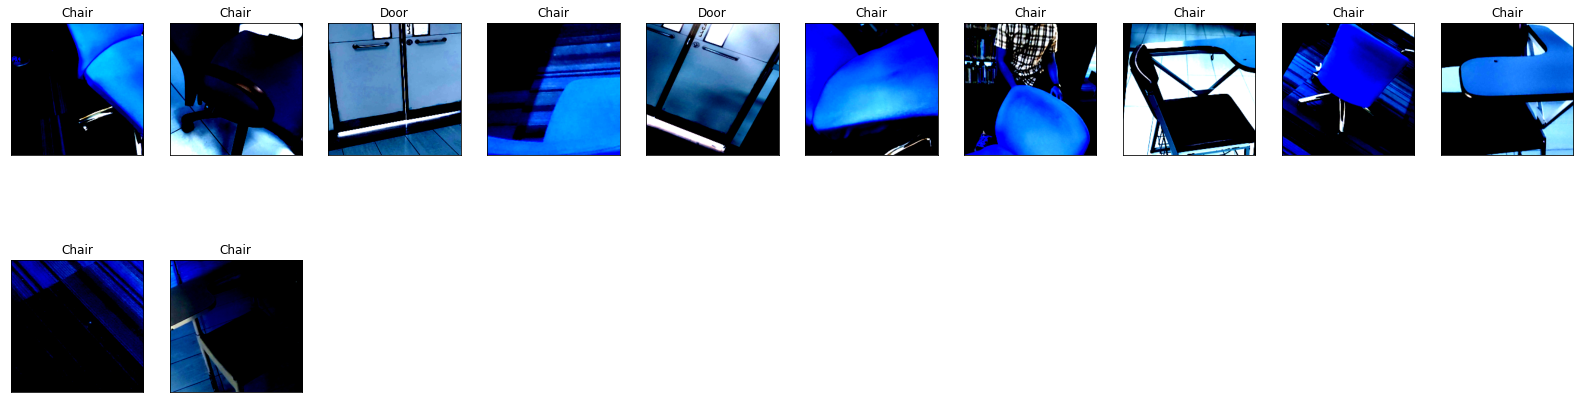

In [21]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
numpyImages = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(28, 8))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(numpyImages[idx], (1, 2, 0)))
    classes=['Chair','Door']
    ax.set_title(classes[labels[idx]])

In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
#print(model) 
model.fc = nn.Sequential(nn.Linear(512, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
#Adam => same as stochastic gradient descent + Momentum
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);
print(model)

In [ ]:
for param in model.parameters():
  print(param.data)

In [28]:
epochs = 1
steps = 0
runningLoss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Utilizing my GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logModelOutput = model.forward(inputs)
        loss = criterion(logModelOutput, labels)
        #back prop + optimizing the parameters
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()
        
        if steps % print_every == 0:
        #if True:
            testLoss = 0
            accuracy = 0
            #turn off dropout and other stuff helpful for training
            evaluationStart = time.time()
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logModelOutput = model.forward(inputs)
                    batchLoss = criterion(logModelOutput, labels)
                    
                    testLoss += batchLoss.item()
                    
                    # Calculate accuracy
                    probabilityOutput = torch.exp(logModelOutput)
                    topProbability, predictedClass = probabilityOutput.topk(1, dim=1)
                    predictedClass = torch.squeeze(predictedClass) 
                    print('Predicted Class',predictedClass)
                    print('Actual Class   ',labels)
                    equals = (predictedClass == labels)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            evaluationEnd = time.time()
            print(f"Epoch {steps}.. "
                  f"Train loss: {runningLoss/print_every:.3f}.. "
                  f"Test loss: {testLoss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}"
                  f" Eval Time Per Image: {(evaluationEnd-evaluationStart)/len(test_loader):.3f}"
                 )
            running_loss = 0
            model.train()

Predicted Class tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Actual Class    tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted Class tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Actual Class    tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted Class tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Actual Class    tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted Class tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Actual Class    tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted Class tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Actual Class    tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted Class tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Actual Class    tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted Class tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dev

KeyboardInterrupt: 

In [29]:
save=torch.save(model.state_dict(), 'chairdoorLatest.pth')

In [30]:
print('Hekiw')

Hekiw


In [ ]:
state_dict = torch.load('chairdoorLatest.pth')
print(state_dict.keys())
print(model)

In [ ]:
print(model.conv1.weight)

In [115]:
from pathlib import Path
from PIL import Image



trans = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

image = Image.open(Path('C:/Users/Laraib Zafar/Transfer Learning/LaraibChair.jpeg'))


input = trans(image)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input = input.to(device)

#utput = model.forward(input[None, ...])
model.eval()
output = model.forward(input[None])

probabilityOutput = torch.exp(output)
topProbability, predictedClass = probabilityOutput.topk(1, dim=1)
predictedClass = torch.squeeze(predictedClass) 

print(input[None].shape)
print(predictedClass)
mode = torch.mode(predictedClass,0)
print(classes[mode[0].item()])


torch.Size([1, 3, 224, 224])
tensor(0, device='cuda:0')
Chair


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Chair')

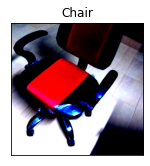

In [116]:
fig = plt.figure(figsize=(28, 8))
ax = fig.add_subplot(2, 20/2,1, xticks=[], yticks=[])
plt.imshow(np.transpose(input.cpu().numpy(), (1, 2, 0)))
ax.set_title(classes[mode[0].item()])